<h2>IMPORTS

In [1]:
import os
import glob

import numpy as np
print('numpy: %s' % np.__version__)
import pandas as pd
print('pandas: %s' % pd.__version__)
# import pandas_bokeh

import matplotlib.pylab as plt
print('matplotlib: %s' % plt.__version__)
import matplotlib
import seaborn as sns
import datetime
from datetime import date

import calendar
from calendar import monthrange
import holidays

from pandas_profiling import ProfileReport

%matplotlib inline

numpy: 1.19.2
pandas: 1.2.2
matplotlib: 1.19.2


<h2>Alle Dateien die im Ordner sind werden eingelesen und zum Dataframe hinzugefügt</h3>

In [2]:
list_df=[]
list_of_dates=[]
by_day_df = pd.DataFrame()


#get csv files and sort them
csv_files = glob.glob("*.csv")
csv_files.sort(key=os.path.getctime)

date_time_str = '2019-11-01 04:00:00'
date_time_start = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

date_time_str = '2019-11-01'
date_time_first = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_time_str = '2020-01-31'
date_time_end = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_list= pd.date_range(date_time_first , date_time_end, freq='D')


austria_holidays = holidays.CountryHoliday('AT', prov=1)

austria_holidays = austria_holidays['2019-11-01': '2020-11-01']

austria_holidays = date_list.isin(austria_holidays)

#Kapazität des Busmodells 15A - Mercedes Benz Citaro GNG 265 MB
kapaz = 129
    
for i, filename in enumerate (csv_files):
    
    #print(i, filename)
    
    #read the data and dont take the last column
    puffer_df= pd.read_csv(filename, index_col=None, header= 0,usecols=[0,1,2,3],decimal = ",", delimiter=";")

#     print(puffer_df)
    
    #Datum
    
    for k in range (4,25):

        if k == 24 :
            #Zeit ist statt 24 am nächsten halt 23:59:59
            date_time_start = date_time_start.replace(hour = 23, minute = 59, second = 59)

        else:
            #Datum ist nun um eine Stunde vorgestellt
            date_time_start = date_time_start.replace(hour = k)

        #HIER muss es zugewiesen werden bevor die stunde wieder verändert wird!!!!
        list_of_dates.append(date_time_start)
            
        
    puffer_df.insert(0,'Datum',list_of_dates)
    list_of_dates.clear()

    last_of_month = monthrange(date_time_start.year, date_time_start.month)[1]  

    if date_time_start.month != 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(month = date_time_start.month + 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    elif date_time_start.month == 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(year = date_time_start.year +1, month = 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    else:
        date_time_start = date_time_start.replace(day = date_time_start.day + 1, hour = 4 , minute = 0, second = 0)
        
    #ENDE von Datum
    
    
    puffer_df.insert(1,'Wochentag',calendar.day_name[date_list[i].weekday()])
    puffer_df.insert(6,'Kapazität',puffer_df['Istfahrtenzahl']*kapaz)
    puffer_df.insert(7,'Feiertag',austria_holidays[i].astype(int))
    


    #vor dem Berechnen die NAN VALUES mit '0' ersetzen
    puffer_df.fillna(0, inplace = True)
    
    #stuff für die monats dataframe
    summe = puffer_df['P hochgerechnet'].sum()
    summesoll = puffer_df['Sollfahrtenzahl'].sum()
    summeist = puffer_df['Istfahrtenzahl'].sum()
    prozent = float(summeist/summesoll)*100
    kapaz_daily = summeist*kapaz
    
    

    row_month = {'Datum': date_list[i], 'Wochentag': calendar.day_name[date_list[i].weekday()],
                 'P hochgerechnet': summe, 'Sollfahrtenzahl':summesoll, 'Istfahrtenzahl':summeist,
                 'Genauigkeit':prozent,'Kapazität':kapaz_daily, 'Feiertag':austria_holidays[i].astype(int) }
    
    by_day_df = by_day_df.append(row_month , ignore_index = True)
    
    list_df.append(puffer_df) #!!!!
    
    by_hour_df = pd.concat(list_df, ignore_index = True)
    
    #print(puffer_df)
    #print(summe,summesoll,summeist,prozent)

by_day_df = by_day_df.reindex(columns=['Datum','Wochentag','P hochgerechnet','Sollfahrtenzahl','Istfahrtenzahl','Genauigkeit','Kapazität','Feiertag'])

In [ ]:
by_day_df.to_excel('daily_values.xlsx')
by_hour_df.to_excel('hourly_values.xlsx')

In [3]:
by_day_df.head()

,Datum,Wochentag,P hochgerechnet,Sollfahrtenzahl,Istfahrtenzahl,Genauigkeit,Kapazität,Feiertag
0,2019-11-01,Friday,4936.608333,215.0,160.0,74.418605,20640.0,1.0
1,2019-11-02,Saturday,6379.658333,224.0,172.0,76.785714,22188.0,0.0
2,2019-11-03,Sunday,6260.500000,215.0,210.0,97.674419,27090.0,0.0
3,2019-11-04,Monday,11992.383532,317.0,275.0,86.750789,35475.0,0.0
4,2019-11-05,Tuesday,13416.813492,317.0,294.0,92.744479,37926.0,0.0


<AxesSubplot:xlabel='Datum'>

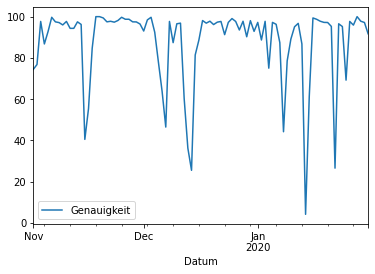

In [3]:
# %matplotlib qt
by_day_df.plot(x="Datum", y="Genauigkeit", kind= "line")

In [9]:
genauigkeits_summe = by_day_df['Genauigkeit'].mean()
print(genauigkeits_summe)

87.93041475748147


In [4]:
by_day_df.keys()

Index(['Datum', 'Wochentag', 'P hochgerechnet', 'Sollfahrtenzahl',
       'Istfahrtenzahl', 'Genauigkeit', 'Kapazität', 'Feiertag'],
      dtype='object')

In [4]:
by_hour_df.head()

,Datum,Wochentag,Tageszeit,Sollfahrtenzahl,Istfahrtenzahl,P hochgerechnet,Kapazität,Feiertag
0,2019-11-01 04:00:00,Friday,04:00 - 04:59,4,4,30.000000,516,1
1,2019-11-01 05:00:00,Friday,05:00 - 05:59,10,7,87.083333,903,1
2,2019-11-01 06:00:00,Friday,06:00 - 06:59,8,6,95.333333,774,1
3,2019-11-01 07:00:00,Friday,07:00 - 07:59,8,6,97.333333,774,1
4,2019-11-01 08:00:00,Friday,08:00 - 08:59,12,8,195.000000,1032,1


In [6]:
by_hour_df.keys()

Index(['Datum', 'Wochentag', 'Tageszeit', 'Sollfahrtenzahl', 'Istfahrtenzahl',
       'P hochgerechnet', 'Kapazität', 'Feiertag'],
      dtype='object')

In [7]:
by_day_df.describe()

,P hochgerechnet,Sollfahrtenzahl,Istfahrtenzahl,Genauigkeit,Kapazität,Feiertag
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,18134.385775,280.728261,246.695652,87.930415,31823.739130,0.065217
std,6996.957012,46.663891,68.778948,19.055616,8872.484319,0.248262
min,4594.699567,215.000000,13.000000,4.100946,1677.000000,0.000000
25%,11176.834065,224.000000,209.000000,88.328076,26961.000000,0.000000
50%,21851.802537,312.000000,276.000000,96.529968,35604.000000,0.000000
75%,24091.964884,317.000000,306.250000,97.674419,39506.250000,0.000000
max,28617.187315,317.000000,317.000000,100.000000,40893.000000,1.000000


In [8]:
by_hour_df.describe()

,Sollfahrtenzahl,Istfahrtenzahl,P hochgerechnet,Kapazität,Feiertag
count,1932.000000,1932.000000,1932.000000,1932.000000,1932.000000
mean,13.368012,11.747412,863.542180,1515.416149,0.065217
std,4.269734,4.932309,651.001529,636.267877,0.246973
min,4.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,8.000000,308.173199,1032.000000,0.000000
50%,13.000000,12.000000,756.525953,1548.000000,0.000000
75%,16.000000,16.000000,1308.095472,2064.000000,0.000000
max,23.000000,23.000000,3196.918908,2967.000000,1.000000


In [77]:
print("INFO")
print(by_day_df.info())
print(by_hour_df.info())

print("NULL VALUES?") 
print(by_day_df.isnull())
print(by_hour_df.isnull())

print("by_day")
print(np.where(pd.isnull(by_day_df)))
print("by_hour")
print(np.where(pd.isnull(by_hour_df)))

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Datum            92 non-null     datetime64[ns]
 1   Wochentag        92 non-null     object        
 2   P hochgerechnet  92 non-null     float64       
 3   Sollfahrtenzahl  92 non-null     float64       
 4   Istfahrtenzahl   92 non-null     float64       
 5   Genauigkeit      92 non-null     float64       
 6   Kapazität        92 non-null     float64       
 7   Feiertag         92 non-null     float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 5.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1932 entries, 0 to 1931
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Datum            1932 non-null   datetime64[ns]
 1   Wochentag        

In [ ]:
##profile report für STUNDEN

report = ProfileReport(by_hour_df, title='Pandas Profiling Report')

report.to_widgets()

In [ ]:
#profile report für TAGE

report = ProfileReport(by_day_df, title='Pandas Profiling Report')

report.to_widgets()

<h2> innerhalb Notebook oder interaktives fenster

In [6]:
#interactive plotting in separate window
%matplotlib qt 

#%matplotlib inline

In [ ]:
plt.close("all")

<h2>density plot

In [ ]:
by_hour_df.plot(x="Datum", y="P hochgerechnet", kind= "kde")

In [ ]:
by_day_df.plot(x="Datum", y="P hochgerechnet", kind= "kde")

<h2>SPEICHERN DER GRAFIKEN

In [ ]:
num_posts_by_author_plot = by_hour_df.plot(x="Datum", y="P hochgerechnet", kind= "kde")


num_posts_by_author_plot.set_xlabel('Number of Posts on Marginal Revolution')

num_posts_by_author_plot.set_ylabel('Number of Posts on Marginal Revolution')

fig = num_posts_by_author_plot.get_figure()
fig.savefig('Grafiken-BA/num_posts_by_author_plot.png', bbox_inches="tight")

In [ ]:
by_day_df.plot(x="Datum", y="P hochgerechnet", kind= "kde")

In [ ]:
by_day_df["P hochgerechnet"].plot.kde() #erzeugt die gleiche Plot wie oben!

<h2>Boxplot?

In [6]:
by_hour_df.boxplot()

<AxesSubplot:>

<h2>Zwei X Werte in einem Plot

In [11]:
by_hour_df.plot(x="Datum", y=["P hochgerechnet", "Kapazität"], kind= "line")

<AxesSubplot:xlabel='Datum'>

In [12]:
by_day_df.plot(x="Datum", y=["P hochgerechnet", "Kapazität"], kind= "line")

<AxesSubplot:xlabel='Datum'>

<h2>Zwei Werte in einem Plot, aber mit mehr Customizing

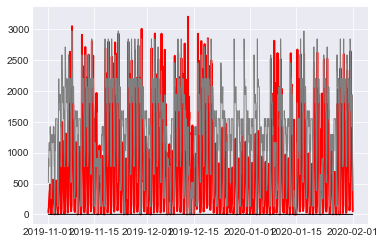

In [16]:
plt.style.use('seaborn-darkgrid')

plt.plot("Datum","P hochgerechnet",color="red", data = by_hour_df,linewidth=2)
plt.plot("Datum","Kapazität", data = by_hour_df,color="grey", linewidth=1)
# plt.plot("Datum","Feiertag", data = by_hour_df,color="black", linewidth=1)




<h2>Lollipop plot, histogram macht da mehr sinn

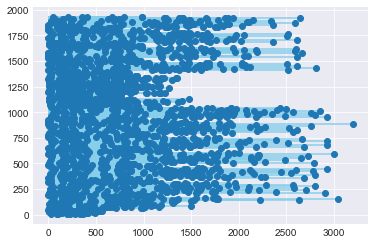

In [17]:
my_range=range(1,len(by_hour_df.index)+1)

plt.hlines(y=my_range, xmin=0, xmax=by_hour_df['P hochgerechnet'], color='skyblue')
plt.plot(by_hour_df['P hochgerechnet'], my_range, "o")


<h2> Subplot: Alle Plots in einem

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

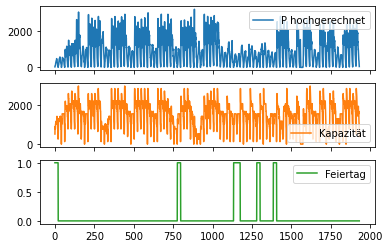

In [7]:
#plt.style.use('seaborn-darkgrid')
by_hour_df_smaller = by_hour_df.drop(columns= ["Datum","Tageszeit","Sollfahrtenzahl","Istfahrtenzahl"])

by_hour_df_smaller.plot(subplots=True)

In [67]:
by_hour_df.plot(subplots=True)

array([<AxesSubplot:xlabel='Datum'>, <AxesSubplot:xlabel='Datum'>,
       <AxesSubplot:xlabel='Datum'>, <AxesSubplot:xlabel='Datum'>,
       <AxesSubplot:xlabel='Datum'>], dtype=object)

In [13]:
by_day_df.plot(subplots=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

<h2>Seaborn Histogram plots, sind schöner

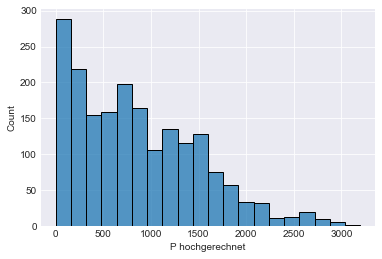

In [21]:
sns.histplot(by_hour_df["P hochgerechnet"])
plt.show()

#das gleiche nur anders
# sns.displot(by_hour_df["P hochgerechnet"])
# plt.show()

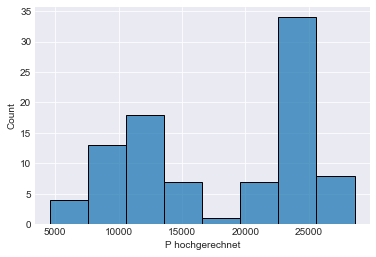

In [22]:
sns.histplot(by_day_df["P hochgerechnet"])
plt.show()

# sns.displot(by_day_df["P hochgerechnet"])
# plt.show()

<h2> normale histogram

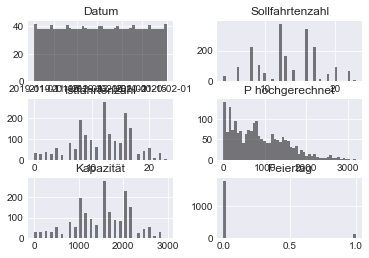

In [23]:
by_hour_df.hist(color="k", alpha=0.5, bins=50);

<h2> Lag Plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

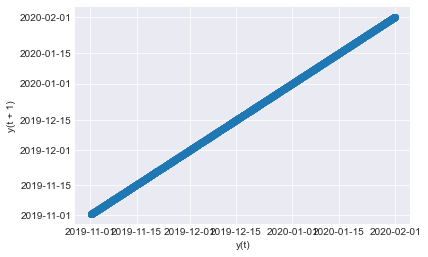

In [24]:
from pandas.plotting import lag_plot

plt.figure()

lag_plot(by_hour_df["Datum"])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

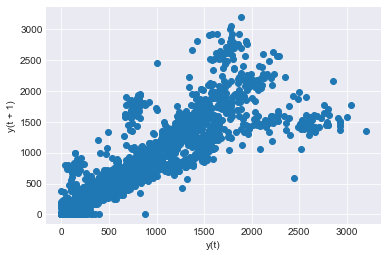

In [25]:
from pandas.plotting import lag_plot

plt.figure()

lag_plot(by_hour_df["P hochgerechnet"])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

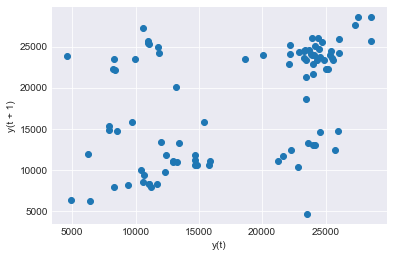

In [26]:
from pandas.plotting import lag_plot

plt.figure()

lag_plot(by_day_df["P hochgerechnet"])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

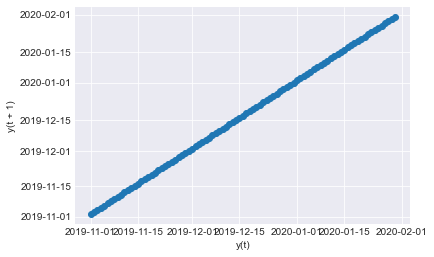

In [27]:
from pandas.plotting import lag_plot

plt.figure()

lag_plot(by_day_df["Datum"])

<h2> Autocorrelation

In [5]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(by_hour_df["P hochgerechnet"])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

<h2> Partial Autocorrelation

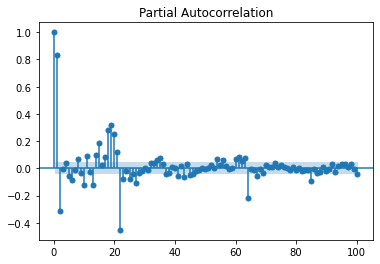

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(by_hour_df["P hochgerechnet"], lags=100)

<h2> Weitere interessante Plots

In [107]:
sns.lineplot(data = by_hour_df["P hochgerechnet"])
plt.show()

Line Plot Täglich

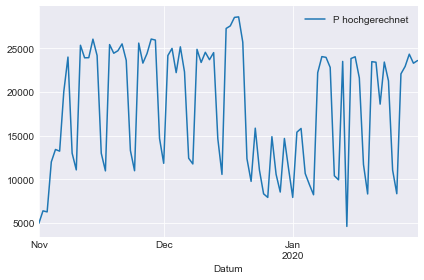

In [34]:
by_day_df.plot(x= "Datum", y="P hochgerechnet", kind="line")

plt.tight_layout()
plt.show()

Line Plot Stündlich

In [7]:
by_hour_df.plot(x="Tageszeit", y="P hochgerechnet", kind="line")

plt.title("Eingänge der Passagiere nach Tageszeit", fontsize = 35) 
plt.legend(fontsize = 35)
plt.xlabel('Tageszeit', fontsize = 35) 
plt.ylabel('Eingänge der Passagiere', fontsize = 35) 
plt.tight_layout()

plt.show()

Line Plot Täglich

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

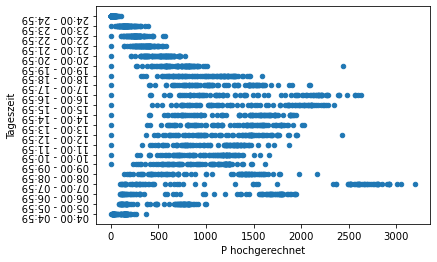

In [12]:
by_hour_df.plot(x="P hochgerechnet" , y="Tageszeit", kind="scatter")
# plt.yticks(rotation=180)


Scatter Plot Eingänge vs Kapazität

<AxesSubplot:xlabel='P hochgerechnet', ylabel='Kapazität'>

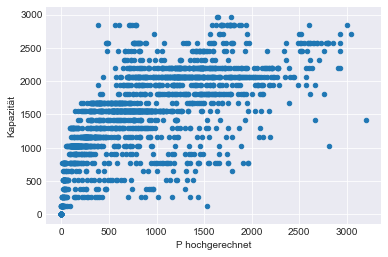

In [60]:
by_hour_df.plot(x= "P hochgerechnet", y="Kapazität", kind="scatter")

Scatter Plot Eingänge vs Wochentag

<AxesSubplot:xlabel='Wochentag', ylabel='P hochgerechnet'>

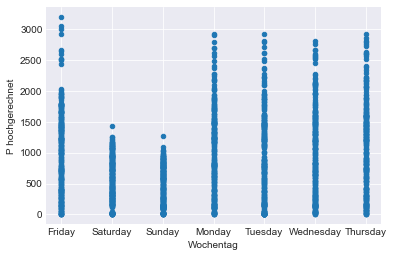

In [74]:
by_hour_df.plot(x= "Wochentag", y="P hochgerechnet", kind="scatter")

<h2> Bokeh visualisierung, schöner und zusätzliche Konfigurierung

In [18]:
pandas_bokeh.output_notebook()

#pandas_bokeh.output_file('chart.html')

#kind what type of chart do you want to plot? Currently, pandas_bokeh supports the following chart types: line, point, step, scatter, bar, histogram, area, pie and map.

Loading BokehJS ...

In [96]:
by_hour_df.plot_bokeh(
    kind='line',
    x='Datum',
    y='P hochgerechnet',
    figsize=(2000, 1000),
    #ylim=(0, 2000),
    xlabel='Datum',
    ylabel='Passagier Einstiege',
    title='Einstiege nach Datum'
)

Figure(id='1519', ...)

In [66]:
# # reduce data size to one week
# week = by_hour_df["Datum"]['2019-11-01':'2019-11-30']

# week.head()

<h2> Decomposing the Data: Trend, Seasonality

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose

#by_hour_df mit by_day_df eretzen um Tage zu sehen, P hochgerechnet

decompose = by_hour_df.set_index("Datum")

print(decompose["P hochgerechnet"])

#period = Anzahl der Beobachtungen/2
result = seasonal_decompose(decompose["P hochgerechnet"], model='additive', period= 966)
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

Datum
2019-11-01 04:00:00     30.000000
2019-11-01 05:00:00     87.083333
2019-11-01 06:00:00     95.333333
2019-11-01 07:00:00     97.333333
2019-11-01 08:00:00    195.000000
                          ...    
2020-01-31 20:00:00    663.568328
2020-01-31 21:00:00    406.522410
2020-01-31 22:00:00    356.000000
2020-01-31 23:00:00    209.000000
2020-01-31 23:59:59     49.000000
Name: P hochgerechnet, Length: 1932, dtype: float64
Datum
2019-11-01 04:00:00   NaN
2019-11-01 05:00:00   NaN
2019-11-01 06:00:00   NaN
2019-11-01 07:00:00   NaN
2019-11-01 08:00:00   NaN
                       ..
2020-01-31 20:00:00   NaN
2020-01-31 21:00:00   NaN
2020-01-31 22:00:00   NaN
2020-01-31 23:00:00   NaN
2020-01-31 23:59:59   NaN
Name: trend, Length: 1932, dtype: float64
Datum
2019-11-01 04:00:00    -667.249695
2019-11-01 05:00:00     -29.080765
2019-11-01 06:00:00    1099.291392
2019-11-01 07:00:00    1962.913114
2019-11-01 08:00:00     865.162964
                          ...     
2020-01-31 20:00:0

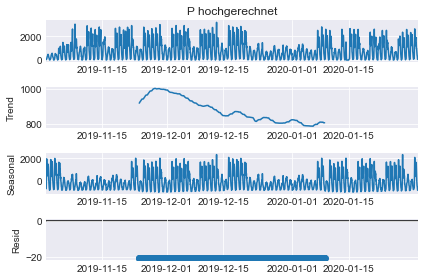

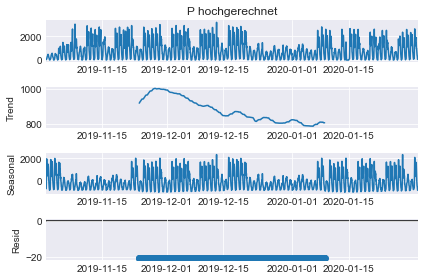

In [82]:
# %matplotlib qt

result.plot()
pyplot.show()

In [ ]:
# sns.regplot('Tageszeit', 'P hochgerechnet', data=by_hour_df)

In [13]:
# by_hour_df = by_hour_df.set_index("Datum")
    
wochentag = by_hour_df['2020-01-21':'2020-01-21']
wochenende = by_hour_df['2020-01-19':'2020-01-19']

wochentag

,Wochentag,Tageszeit,Sollfahrtenzahl,Istfahrtenzahl,P hochgerechnet,Kapazität,Feiertag
Datum,,,,,,,
2020-01-21 04:00:00,Tuesday,04:00 - 04:59,8,8,169.000000,1032,0
2020-01-21 05:00:00,Tuesday,05:00 - 05:59,20,20,764.388250,2580,0
2020-01-21 06:00:00,Tuesday,06:00 - 06:59,22,22,1762.110400,2838,0
2020-01-21 07:00:00,Tuesday,07:00 - 07:59,20,20,2615.829440,2580,0
2020-01-21 08:00:00,Tuesday,08:00 - 08:59,19,19,1456.565490,2451,0
2020-01-21 09:00:00,Tuesday,09:00 - 09:59,17,17,1243.032130,2193,0
2020-01-21 10:00:00,Tuesday,10:00 - 10:59,16,16,1137.007260,2064,0
2020-01-21 11:00:00,Tuesday,11:00 - 11:59,16,16,1293.367580,2064,0
2020-01-21 12:00:00,Tuesday,12:00 - 12:59,17,17,1437.624550,2193,0


In [6]:
%matplotlib qt

In [22]:
# woche.plot(x="Tageszeit", y="P hochgerechnet", kind="line")

plt.plot("Tageszeit","P hochgerechnet",color="red", data = wochentag,linewidth=6, marker="D", markersize=20, label="Wochentag")
plt.plot("Tageszeit","P hochgerechnet",color="blue", data = wochenende,linewidth=6, marker="D", markersize=20, label="Wochenende")

plt.title('Eingänge der Passagiere nach Tageszeit', fontsize = 80)
plt.xlabel('Tageszeit', fontsize = 75)
plt.ylabel('Eingänge der Passagiere', fontsize = 75)
plt.yticks(fontsize=70)
plt.xticks(fontsize=70, rotation = 90)
plt.grid(color='grey', linewidth=2)
plt.legend(fontsize=60)  

plt.show()


# plt.xticks(fontsize=15)
# matplotlib.pyplot.locator_params(axis=wochentag, nbins=100)
# plt.tight_layout()
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off

plt.show()